In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from tabulate import tabulate
from datasets import load_dataset

from tqdm.notebook import tqdm
from transformers import BertTokenizer
import matplotlib.pyplot as plt

This is a template of the notebook that you should complete and enrich with your own code.

First cells will be the same than the ones of the lab on attention.

# Data loading


In [100]:
dataset = load_dataset("Salesforce/wikitext", "wikitext-2-v1", split="train")
print(dataset)

Dataset({
    features: ['text'],
    num_rows: 36718
})


# Pre-processing / Tokenization

This is a very important step. It maybe boring but very important. In this session we will be lazy, but in real life, the time spent on inspecting and cleaning data is never wasted. It is true for text, but also for everything.



In PyTorch, everything is tensor. Words are replaced by indices. A sentence, is therefore a sequence of indices (long integers). In the first HW, you constructed a `WhiteSpaceTokenizer`. Here we will use an already built tokenizer. It is more appropriate to transformers. It relies on sub-word units, and converts everything in lower case. This is not always the best choice, but here it will be sufficient. To quote the documentation, this tokenizer allows you to:
- Tokenize (splitting strings in sub-word token strings), converttokens strings to ids and back, and encoding/decoding (i.e., tokenizing and converting to integers).
- Add new tokens to the vocabulary in a way that is independent of the underlying structure (BPE, SentencePiece…).
- Manage special tokens (like mask, beginning-of-sentence, etc.): adding them, assigning them to attributes in the tokenizer for easy access and making sure they are not split during tokenization.

Here we are going to use the tokenizer from the well known Bert model, that we can directly download.

In [101]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

In [102]:
def preprocessing_fn(x, tokenizer):
    x["input_ids"] = tokenizer(
        x["text"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    return x


Same celel than in the lab session.

🚧 **TODO** 🚧

Read the documentation about HuggingFace dataset and complete the code below.
You should:
- Shuffle the dataset
- For computational reasons, use only a total of **5000 samples**.
- Tokenize the dataset with the `preprocessing_fn`. (*Hint: use the `Dataset.map` method from HuggingFace*).
- Keep only columns `review_ids` and `label`.
- Make a train/validation split, (**80% / 20%**). Call these dataset `train_set` and `valid_set`.


In [ ]:
# Question 3.1.1
import re

n_samples = 15000  # the number of training example

# We first shuffle the data !
dataset_shuffle = dataset.shuffle(seed=42)  # TODO
print(f"Initial length: {len(dataset_shuffle)}")

# Filter empty samples and Wiki balises
dataset_filtered = dataset_shuffle.filter(lambda x: x["text"].strip() != "")
dataset_filtered = dataset_filtered.filter(lambda x: not re.match(r"^=+\s?.*?=+$", x["text"].strip()))
print(f"After filtering length: {len(dataset_filtered)}")

# Select 5000 samples
dataset_sampled = dataset_filtered.select(range(n_samples))  # TODO
print(f"After sampling length: {len(dataset_sampled)}\n")

# Tokenize the dataset
dataset_tokenized = dataset_sampled.map(
    lambda x: preprocessing_fn(x, tokenizer=tokenizer)
)  # TODO
print(f"Input Ids: {dataset_tokenized[0]["input_ids"]}")
print(f"Text : {dataset_tokenized[0]["text"]}")

# Remove useless columns
dataset_cleaned = dataset_tokenized.remove_columns(["text"])  # TODO
print(dataset_cleaned[0].keys())

# Split the train and validation
dataset_splits = dataset_cleaned.train_test_split(test_size=0.2)  # TODO

document_train_set = dataset_splits["train"]  # TODO
document_valid_set = dataset_splits["test"]  # TODO
print(f"Nb of examples in train set : {len(document_train_set)}")
print(f"Nb of examples in val set : {len(document_valid_set)}")
print(f"Mean length of documents in train set : {np.mean([len(x['input_ids']) for x in document_train_set])}")

Initial length: 36718
After filtering length: 17556
After sampling length: 5000

Input Ids: [1026, 4895, 2243, 1028, 1010, 2460, 1030, 1011, 1030, 8115, 1010, 2152, 3778, 1060, 16515, 2078, 8115, 14186, 2031, 1037, 3609, 4860, 4876, 1026, 4895, 2243, 1028, 11501, 9325, 1998, 2024, 2109, 1999, 5943, 25837, 2015, 1012, 2008, 2003, 1010, 1996, 1026, 4895, 2243, 1028, 1997, 2122, 14186, 4876, 1026, 4895, 2243, 1028, 1037, 9685, 2304, 2303, 1026, 4895, 2243, 1028, 2008, 2038, 1037, 4860, 2485, 2000, 2008, 5159, 2013, 1996, 3103, 1012, 2044, 2027, 2020, 2034, 3107, 2076, 1996, 7675, 1010, 2122, 14186, 2211, 6419, 1996, 7820, 1030, 1011, 1030, 2973, 6351, 8115, 14186, 1999, 3185, 1026, 4895, 2243, 1028, 1012, 2027, 2024, 4846, 1999, 5171, 3486, 7382, 1010, 1026, 4895, 2243, 1028, 1998, 1996, 2047, 3617, 1026, 4895, 2243, 1028, 2143, 13996, 3001, 1010, 12945, 1026, 4895, 2243, 1028, 1026, 4895, 2243, 1028, 1010, 2152, 1030, 1011, 1030, 2203, 1000, 8608, 1000, 1026, 4895, 2243, 1028, 1998, 2060

In [104]:
# Question 3.1.2

def tokens_padding(doc_ids, R):
    """Return a padded sentence with [PAD] token (id=0) to avoid border issues
    when extracting the context.

    Input:
        doc_ids: (list[int]): token IDs of a document.
        R (int): context window radius.

    Ouput:
        padded_doc_ids: (list[int]): token IDs of a document with [PAD] token at the begin and end.
    """

    zero_padding = [0] * R
    padded_doc_ids = zero_padding + doc_ids + zero_padding

    return padded_doc_ids


def extract_words_contexts(doc_ids, R):
    """Extract (word, context) pairs from a list of token IDs.

    Inputs:
        doc_ids (list[int]): token IDs of a document.
        R (int): context window radius.

    Outputs:
        dict: A dictionary with two keys:
            - 'word_ids' (list[int]): the list of center word IDs.
            - 'contexts' (list[list[int]]): the corresponding context IDs
            for each center word, each of fixed size 2R.
    """
    contexts = []

    padded_doc_ids = tokens_padding(doc_ids, R)

    for i in range(R, len(padded_doc_ids) - R):

        context_ids_right = padded_doc_ids[(i + 1) : (i + 1 + R)]
        context_ids_left = padded_doc_ids[(i - R) : i]

        contexts.append(context_ids_left + context_ids_right)

    return {"word_ids": doc_ids, "contexts": contexts}

## -- Testing --
dic = extract_words_contexts(doc_ids=document_train_set[0]["input_ids"], R=6)
words, contexts = dic["word_ids"], dic["contexts"]

print(
    f"Full initial sentence : '{" ".join(tokenizer.convert_ids_to_tokens(document_train_set[0]['input_ids']))}'\n"
)
print(f"Word id : {words[0]}")
print(f"Context ids retreived : {contexts[0]}")

print(f"Word : {tokenizer.convert_ids_to_tokens(words[0])}")
print(f"Context retreived : {tokenizer.convert_ids_to_tokens(contexts[0])}")

print(f"\nContexts length : {set([len(i) for i in contexts])}")

Full initial sentence : 'dr ##am ##matic ##a : the very best of yoko shi ##mo ##mura ( 2008 )'

Word id : 2852
Context ids retreived : [0, 0, 0, 0, 0, 0, 3286, 12644, 2050, 1024, 1996, 2200]
Word : dr
Context retreived : ['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '##am', '##matic', '##a', ':', 'the', 'very']

Contexts length : {12}


In [ ]:
# Question 3.1.3

def flatten_dataset_to_list(dataset, R):
    """Applies extract_words_contexts on a whole dataset, returning
    a list containing all the examples of (words, context)."""

    dataset = dataset.map(lambda x: extract_words_contexts(x["input_ids"], R=R))

    flatten_word_ids = [word for sentence in dataset for word in sentence["word_ids"]]

    flatten_word_contexts = [
        context for sentence in dataset for context in sentence["contexts"]
    ]

    return flatten_word_ids, flatten_word_contexts

## -- Testing --

flatten_word_ids, flatten_word_contexts = flatten_dataset_to_list(
    document_train_set, R=6
)

id = np.random.randint(0, 100)
print(f"First word id: {flatten_word_ids[id]}")
print(f"Context ids: {flatten_word_contexts[id]}\n")

print(f"First word: {tokenizer.convert_ids_to_tokens(flatten_word_ids[id])}")
print(f"Context: {tokenizer.convert_ids_to_tokens(flatten_word_contexts[id])}")

In [ ]:
# Question 3.1.4

R = 6
train_word_ids, train_contexts = flatten_dataset_to_list(document_train_set, R=R)
val_word_ids, val_contexts = flatten_dataset_to_list(document_valid_set, R=R)

In [107]:
# Question 3.1.5

from torch.utils.data import Dataset

class WikiPediaWord2Vec(Dataset):

    def __init__(self, word_ids: list, contexts: list):
        self.word_ids = word_ids
        self.contexts = contexts
        assert len(self.contexts) == len(self.word_ids)

    def __len__(self):
        return len(self.word_ids)

    def __getitem__(self, idx):
        return self.word_ids[idx], self.contexts[idx]
    
train_set = WikiPediaWord2Vec(train_word_ids, train_contexts)
valid_set = WikiPediaWord2Vec(val_word_ids, val_contexts)

In [ ]:
# Question 3.1.6

def collate_fn(batch, vocab_size: int, R: int, K: int):
    """
    Builds a batch for Word2Vec training by grouping target words with their positive
    contexts and sampling random negative contexts from the vocabulary.
    """
    word_ids = torch.tensor([word_id for word_id, _ in batch], dtype=int).unsqueeze(1)
    positive_context_ids = torch.tensor([context for _, context in batch], dtype=int)
    negative_context_ids = torch.randint(
        0, vocab_size, (positive_context_ids.shape[0], 2 * K * R), dtype=int
    )

    return {
        "word_id": word_ids,
        "positive_context_ids": positive_context_ids,
        "negative_context_ids": negative_context_ids,
    }

# -- Testing --

batch_size = 32
K = 2
vocab_size = tokenizer.vocab_size

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    collate_fn=lambda batch: collate_fn(
        batch, vocab_size=vocab_size, R=R, K=K
    ),
)

# Word2Vec Model

## Definition

In [ ]:
# -- Question 3.2.9

class Word2Vec(nn.Module): 

    def __init__(self, vocab_size: int, embed_dim: int):
        super().__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

        # Define two embedding layers: one for target words and one for context words
        self.lookup_table_words = nn.Embedding(vocab_size, embed_dim)
        self.lookup_table_contexts = nn.Embedding(vocab_size, embed_dim)

    def forward(self, word_ids, pos_context_ids, neg_context_ids):
        
        # [B, d]
        w = self.lookup_table_words(word_ids).squeeze(1)

        # [B, 2R, d] and [B, 2R*K, d]$
        w_pos_context = self.lookup_table_contexts(pos_context_ids)
        w_neg_context = self.lookup_table_contexts(neg_context_ids)
        
        # Similarities 
        pos_score = torch.bmm(w_pos_context, w.unsqueeze(2)).squeeze(2)
        neg_score = torch.bmm(w_neg_context, w.unsqueeze(2)).squeeze(2)

        # Sigmoid + loss
        pos_loss = F.logsigmoid(pos_score)
        neg_loss = F.logsigmoid(-neg_score)
        loss = -(pos_loss.sum(1) + neg_loss.sum(1)) / (pos_score.size(1) + neg_loss.size(1))
        loss = loss.mean()

        return loss

embed_dim = 64
word2vec = Word2Vec(vocab_size=vocab_size, embed_dim=embed_dim)

batch = next(iter(train_loader))
word2vec(batch["word_id"], batch["positive_context_ids"], batch["negative_context_ids"])

## Training

In [121]:
# -- Question 3.2.10
import os 
import json 

class Trainer :
    """
    Trainer for Word2Vec model.
    """
    def __init__(self, model, train_set : Word2Vec, valid_set : Word2Vec, optimizer, vocab_size, R, K, collate_fn, model_dump_name='model.pth', device='cuda'):
        
        self.model= model
        self.optimizer = optimizer

        self.train_set= train_set
        self.valid_set= valid_set
        self.collate_fn = collate_fn

        self.vocab_size= vocab_size
        self.R= R
        self.K= K

        self.model_dump_name= model_dump_name
        self.device= device

    def _get_data_loader(self, batch_size: int):
        """Get DataLoader for training and validation sets."""
        train_loader = DataLoader(
            self.train_set,
            batch_size=batch_size,
            collate_fn=lambda batch: self.collate_fn(
                batch, vocab_size=self.vocab_size, R=self.R, K=self.K
            ),
        )
        valid_loader = DataLoader(
            self.valid_set,
            batch_size=batch_size,
            collate_fn=lambda batch: self.collate_fn(
                batch, vocab_size=self.vocab_size, R=self.R, K=self.K
            ),
        )
        return train_loader, valid_loader

    
    def _step(self, batch):
        """Perform a training/validation step."""
        word_id= batch['word_id'].to(self.device)
        positive_context_ids= batch['positive_context_ids'].to(self.device)
        negative_context_ids = batch['negative_context_ids'].to(self.device)
                    
        loss = self.model(word_id, positive_context_ids, negative_context_ids)

        return loss
    
    def _log_historic(self, historic, epoch, train_loss, val_loss) :
        historic.append({
            'epoch': epoch,
            'train_loss': train_loss,
            'val_loss': val_loss
        })
        return historic

    def fit(self, nb_epochs: int, batch_size:int):
        """Train the Word2Vec model."""
        self.model.to(self.device)
        train_loader, val_loader = self._get_data_loader(batch_size)

        historic = []
        best_val_loss = np.inf
        best_model_path = None

        for i in range(nb_epochs) :
            
            # Training:
            train_loss = 0 
            self.model.train()
            for batch in tqdm(train_loader, desc=f"Training -- Epoch [{i+1}]") :
                loss = self._step(batch)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()

###################### /!\/!\/!\ -- Question 3.2.11 -- /!\/!\/!\ ######################
            val_loss = 0
            self.model.eval()
            with torch.no_grad() :
                for batch in tqdm(val_loader, desc=f"Validation -- Epoch [{i+1}]") :
                    loss= self._step(batch)
                    
                    val_loss += loss.item()
######################################################################################

            # Logs:
            train_loss /= len(train_loader)
            val_loss /= len(val_loader)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self.save_model(epoch=nb_epochs, batch_size=batch_size, folder_name="best_model")
                print(f"New best model saved at epoch {i+1} with val_loss={val_loss:.4f}")

            historic = self._log_historic(historic, epoch=i+1,
                               train_loss=train_loss,
                               val_loss=val_loss)

            historic = self._log_historic(historic, epoch=i+1, 
                               train_loss=train_loss, 
                               val_loss=val_loss)

            
            print(f"Epoch {i+1}/{nb_epochs} - train_loss: {train_loss:.4f} - val_loss: {val_loss:.4f}")

        return self.model, historic
    
###################### /!\/!\/!\ -- Question 3.2.10 -- /!\/!\/!\ ######################

    def save_model(self, epoch: int, batch_size: int, folder_name: str="checkpoints"):

        os.makedirs(folder_name, exist_ok=True)

        fn_embed_words = f"model_embed_words-{self.model.embed_dim}_radius-{self.R}_ratio-{self.K}_batch-{batch_size}_epoch-{epoch}.ckpt"
        path = os.path.join(folder_name, fn_embed_words)
        torch.save(self.model.lookup_table_words.weight.data, path)

        fn_embed_contexts = f"model_embed_contexts-{self.model.embed_dim}_radius-{self.R}_ratio-{self.K}_batch-{batch_size}_epoch-{epoch}.ckpt"
        path = os.path.join(folder_name, fn_embed_contexts)
        torch.save(self.model.lookup_table_contexts.weight.data, path)

        print(f"Model embeddings saved to {folder_name}")

######################################################################################

    def save_historic(self, historic, epoch: int, batch_size: int):
        """Save the training/validation loss history as a JSON file."""
        filename = f"historic_dim-{self.model.embed_dim}_radius-{self.R}_ratio-{self.K}_batch-{batch_size}_epoch-{epoch}.json"
        os.makedirs("checkpoints", exist_ok=True)
        path = os.path.join("checkpoints", filename)

        with open(path, "w") as f:
            json.dump(historic, f, indent=4)

        print(f"Training history saved to {path}")



In [ ]:
# -- Data settings -- 
R = 10
K = 14

# -- Model settings --
embed_dim = 10

# -- Training settings --
batch_size= 1024
nb_epochs= 20
lr = 1e-3

# -- Data Loadings --
train_word_ids, train_contexts = flatten_dataset_to_list(document_train_set, R=R)
val_word_ids, val_contexts = flatten_dataset_to_list(document_valid_set, R=R)
train_set = WikiPediaWord2Vec(train_word_ids, train_contexts)
valid_set = WikiPediaWord2Vec(val_word_ids, val_contexts)

# -- Model Training --
vocab_size = tokenizer.vocab_size
word2vec = Word2Vec(vocab_size=vocab_size, embed_dim=embed_dim)
optimizer = torch.optim.Adam(word2vec.parameters(), lr=lr)
word2vec_trainer = Trainer(word2vec, train_set, valid_set, optimizer=optimizer, vocab_size=vocab_size, R=R, K=K, collate_fn=collate_fn, device='cuda')

_, historic = word2vec_trainer.fit(batch_size=batch_size, nb_epochs=nb_epochs)

# -- Saving --
word2vec_trainer.save_model(epoch=nb_epochs, batch_size=batch_size)
word2vec_trainer.save_historic(historic, epoch=nb_epochs, batch_size=batch_size)

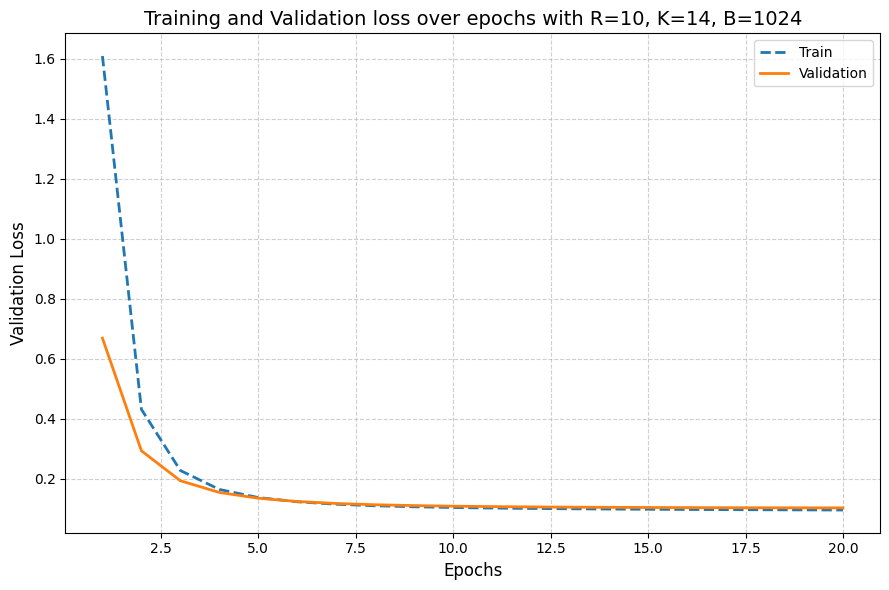

In [125]:
base_dir = "checkpoints/"

files = {
    'Vanilla': os.path.join(base_dir, f"historic_dim-{embed_dim}_radius-{R}_ratio-{K}_batch-{batch_size}_epoch-{nb_epochs}.json"),
}

historics = {}
for batch_size, path in files.items():
    if os.path.exists(path):
        with open(path, "r") as f:
            historics[batch_size] = json.load(f)

plt.figure(figsize=(9,6))

for label, hist in historics.items():
    epochs = [e["epoch"] for e in hist]
    train_loss = [e["train_loss"] for e in hist]
    val_loss = [e["val_loss"] for e in hist]
    plt.plot(epochs, train_loss, '--', linewidth=2, label=f"Train")
    plt.plot(epochs, val_loss, '-', linewidth=2, label=f"Validation")

plt.title("Training and Validation loss over epochs with R=10, K=14, B=1024", fontsize=14)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### Execute to train configurations required for classification notebook.

The output (Word2vec embeddings) will be saved in a `checkpoints/` folder

In [ ]:
# -- Data settings -- 
radius = [5, 10, 15]
ratios = [1, 2, 5]

for R in radius:
    for K in ratios:  

        # -- Data Loadings --
        train_word_ids, train_contexts = flatten_dataset_to_list(document_train_set, R=R)
        val_word_ids, val_contexts = flatten_dataset_to_list(document_valid_set, R=R)
        train_set = WikiPediaWord2Vec(train_word_ids, train_contexts)
        valid_set = WikiPediaWord2Vec(val_word_ids, val_contexts)

        # -- Model Training --
        vocab_size = tokenizer.vocab_size
        word2vec = Word2Vec(vocab_size=vocab_size, embed_dim=embed_dim)
        optimizer = torch.optim.Adam(word2vec.parameters(), lr=lr)
        word2vec_trainer = Trainer(word2vec, train_set, valid_set, optimizer=optimizer, vocab_size=vocab_size, R=R, K=K, collate_fn=collate_fn, device='cuda')

        _, historic = word2vec_trainer.fit(batch_size=batch_size, nb_epochs=nb_epochs)

        # -- Saving --
        word2vec_trainer.save_model(epoch=nb_epochs, batch_size=batch_size)
        word2vec_trainer.save_historic(historic, epoch=nb_epochs, batch_size=batch_size)